We've covered simple linear regression, but that model is rather limited. It's extremely basic, dealing with only one outcome variable and one input. Most of the time we're interested in a relationship between more than two variables. So what can least squares regression do in that circumstance?

The answer is it can still do quite a lot. Least squares regression can handle almost any functional form you pass into it, it will simply estimate the coefficients.

## Multivariable Least Squares

When a least squares regression has more than one independent variable (or input) it is called multivariable least squares linear regression, multiple linear regression, or just multivariable regression. [Note that this is different from "multivariate" regression, which involves more than one _dependent_ variable.]

This type of model is used when there are multiple variables affecting your outcome. For example, let's think about rental costs. If we wanted to model the monthly rental cost of an apartment there are several factors that matter. We could do something simple, say:

$$ Rent = \alpha + SquareFootage $$

And that might not be a terrible model. It makes sense that as square footage of an apartment goes up so would the cost of rent. However, there's probably more to the story than that.

$$ Rent = \alpha + SquareFootage + Bedrooms + Bathrooms + YearBuilt $$

This would seem like a much more robust model. Now all of these relationships are still linear, meaning each additional bedroom affects rent in the same way. The delta to rent will be equivalent for moving from 1 to 2 bedrooms and from 11 to 12. Again, this is the nature of linear regression. As with the simpler models, here again the linear regression algorithm arrives at estimates for coefficients in front of each variable that minimize the sum of squared errors. We'll cover how that algorithm functions in more detail later.

## Categorical Variables

Not all variables have an obvious linear relationship, however. Categorical variables, for one, pose a unique problem here. A __categorical variable__, much like the outcomes we studied when working with classifiers, is a type or category. This can be something like a boolean {True, False} or state {WA, CA, OR, NV...}. Implying a single linear relationship between all of these values wouldn't make sense. Instead we treat each of them individually, allowing for each value to have its own associated coefficient. So if we wanted to include neighborhood in our example model we could do something like:

$$ Rent = \alpha + SquareFootage + Bedrooms + Bathrooms + YearBuilt + Neighborhood $$

In some languages, such as R, this is functionally sufficient and the algorithm will break neighborhood into categories for the various neighborhoods passed into the model. For Python, however, we have to do a little more work. Because these different categories are not linearly related, SKLearn wants separate binary __indicators__ for each. So for every categorical value we have to create a column that is 0 or 1 indicating if the observation is of that category.

To continue with our rent example, let's say our town was broken into three neighborhoods: Downtown, South, and North. Then our specification would look something like:

$$ Rent = \alpha + SquareFootage + Bedrooms + Bathrooms + YearBuilt + Downtown + South $$

There are a few things to note here. Firstly, one category will always be excluded. That's because it will be incorporated into the intercept (the $\alpha$) and we would otherwise run into collinearity problems, which we'll cover more in the next section. Also, each of these categories would typically be mutually exclusive, which makes sense. If a house is in the South, it shouldn't simultaneously be in the North.

Python offers you two real ways to deal with creating these indicators. The first is to do it manually. If this seems hard or complicated to you THEN YOU SHOULD ABSOLUTELY DO IT! It's good programming practice. However, SKLearn (of course) has a [built in function](http://scikit-learn.org/stable/modules/preprocessing.html) called `OneHotEncoder` that will also do this kind of data preparation.

## Linear doesn't have to mean lines...

Now it is worth noting that the model assumes a linear relationship between the predictors and the outcome, but the predictors themselves can take on more complicated forms. For example, if you specified a functional form of:

$$ y = \alpha + x + x^2 $$

That is perfectly doable in multivariable regression as long as you pass through a dataframe where one column is $x$ and the other column is $x^2$. It is not uncommon to see things like sine or cosine when dealing with a seasonal time series. You can get as complicated as you want, though be careful. Adding a lot of terms can destroy your model by violating the assumptions of OLS. We'll get into those assumptions in the next lesson.

## DRILL: Prepare the Data

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR ([Thinkful mirror](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)).

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

The 'population' variable is already set for you, but you will need to create the last three features.  Robbery and Murder are currently continuous variables.  For this model, please use these variables to create  categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0.  You'll use this data and model in a later assignment- for now, just write the code you need to get the data ready.  Don't forget basic data cleaning procedures, either!  Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.


In [32]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
%matplotlib inline

crime = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', header=4)

crime.columns = ['city', 'population', 'violent_crime', 
                 'murder','rape_revised','rape_legacy',
                 'robbery','aggravated_assault','property_crime',
                 'burglary', 'larceny_theft','motor_vehicle_theft','arson' ]
crime['population_squared'] = crime.population**2
crime = crime.drop(columns=['rape_revised'])
#crime['murder_cat'] = if crime['murder'] > 0 return 1, else 0
#crime['robbery_cat'] =
crime = crime.dropna()

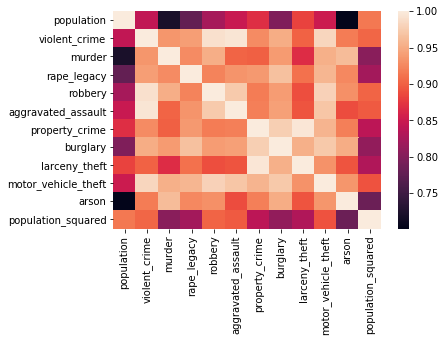

In [33]:
sns.heatmap(crime.corr())
plt.show()

In [39]:
# Removing outliers
def within_x_std(col,x):
    mean = crime[col].mean()
    x_std = crime[col].std()*x
    upper_bound = mean + x_std
    lower_bound = mean - x_std
    return [upper_bound,lower_bound]

population_bounds = within_x_std("population",3)
larceny_bounds = within_x_std("larceny_theft",3)
murder_bounds = within_x_std("murder",3)
robbery_bounds = within_x_std("robbery",3)
burglary_bounds = within_x_std("burglary",3)
arson_bounds = within_x_std("arson",3)
assault_bounds = within_x_std("aggravated_assault",3)
rape_bounds = within_x_std("rape_legacy",3)
violent_crime_bounds = within_x_std("violent_crime",3)

crime = crime[(crime['population'] <= population_bounds[0]) & (crime['population'] >= population_bounds[1])]
crime = crime[(crime['larceny_theft'] <= larceny_bounds[0]) & (crime['larceny_theft'] >= larceny_bounds[1])]
crime = crime[(crime['murder'] <= murder_bounds[0]) & (crime['murder'] >= murder_bounds[1])]
crime = crime[(crime['robbery'] <= robbery_bounds[0]) & (crime['robbery'] >= robbery_bounds[1])]
crime = crime[(crime['burglary'] <= burglary_bounds[0]) & (crime['burglary'] >= burglary_bounds[1])]
crime = crime[(crime['arson'] <= arson_bounds[0]) & (crime['arson'] >= arson_bounds[1])]
crime = crime[(crime['aggravated_assault'] <= assault_bounds[0]) & (crime['aggravated_assault'] >= assault_bounds[1])]
crime = crime[(crime['rape_legacy'] <= rape_bounds[0]) & (crime['rape_legacy'] >= rape_bounds[1])]
crime = crime[(crime['violent_crime'] <= violent_crime_bounds[0]) & (crime['violent_crime'] >= violent_crime_bounds[1])]


/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


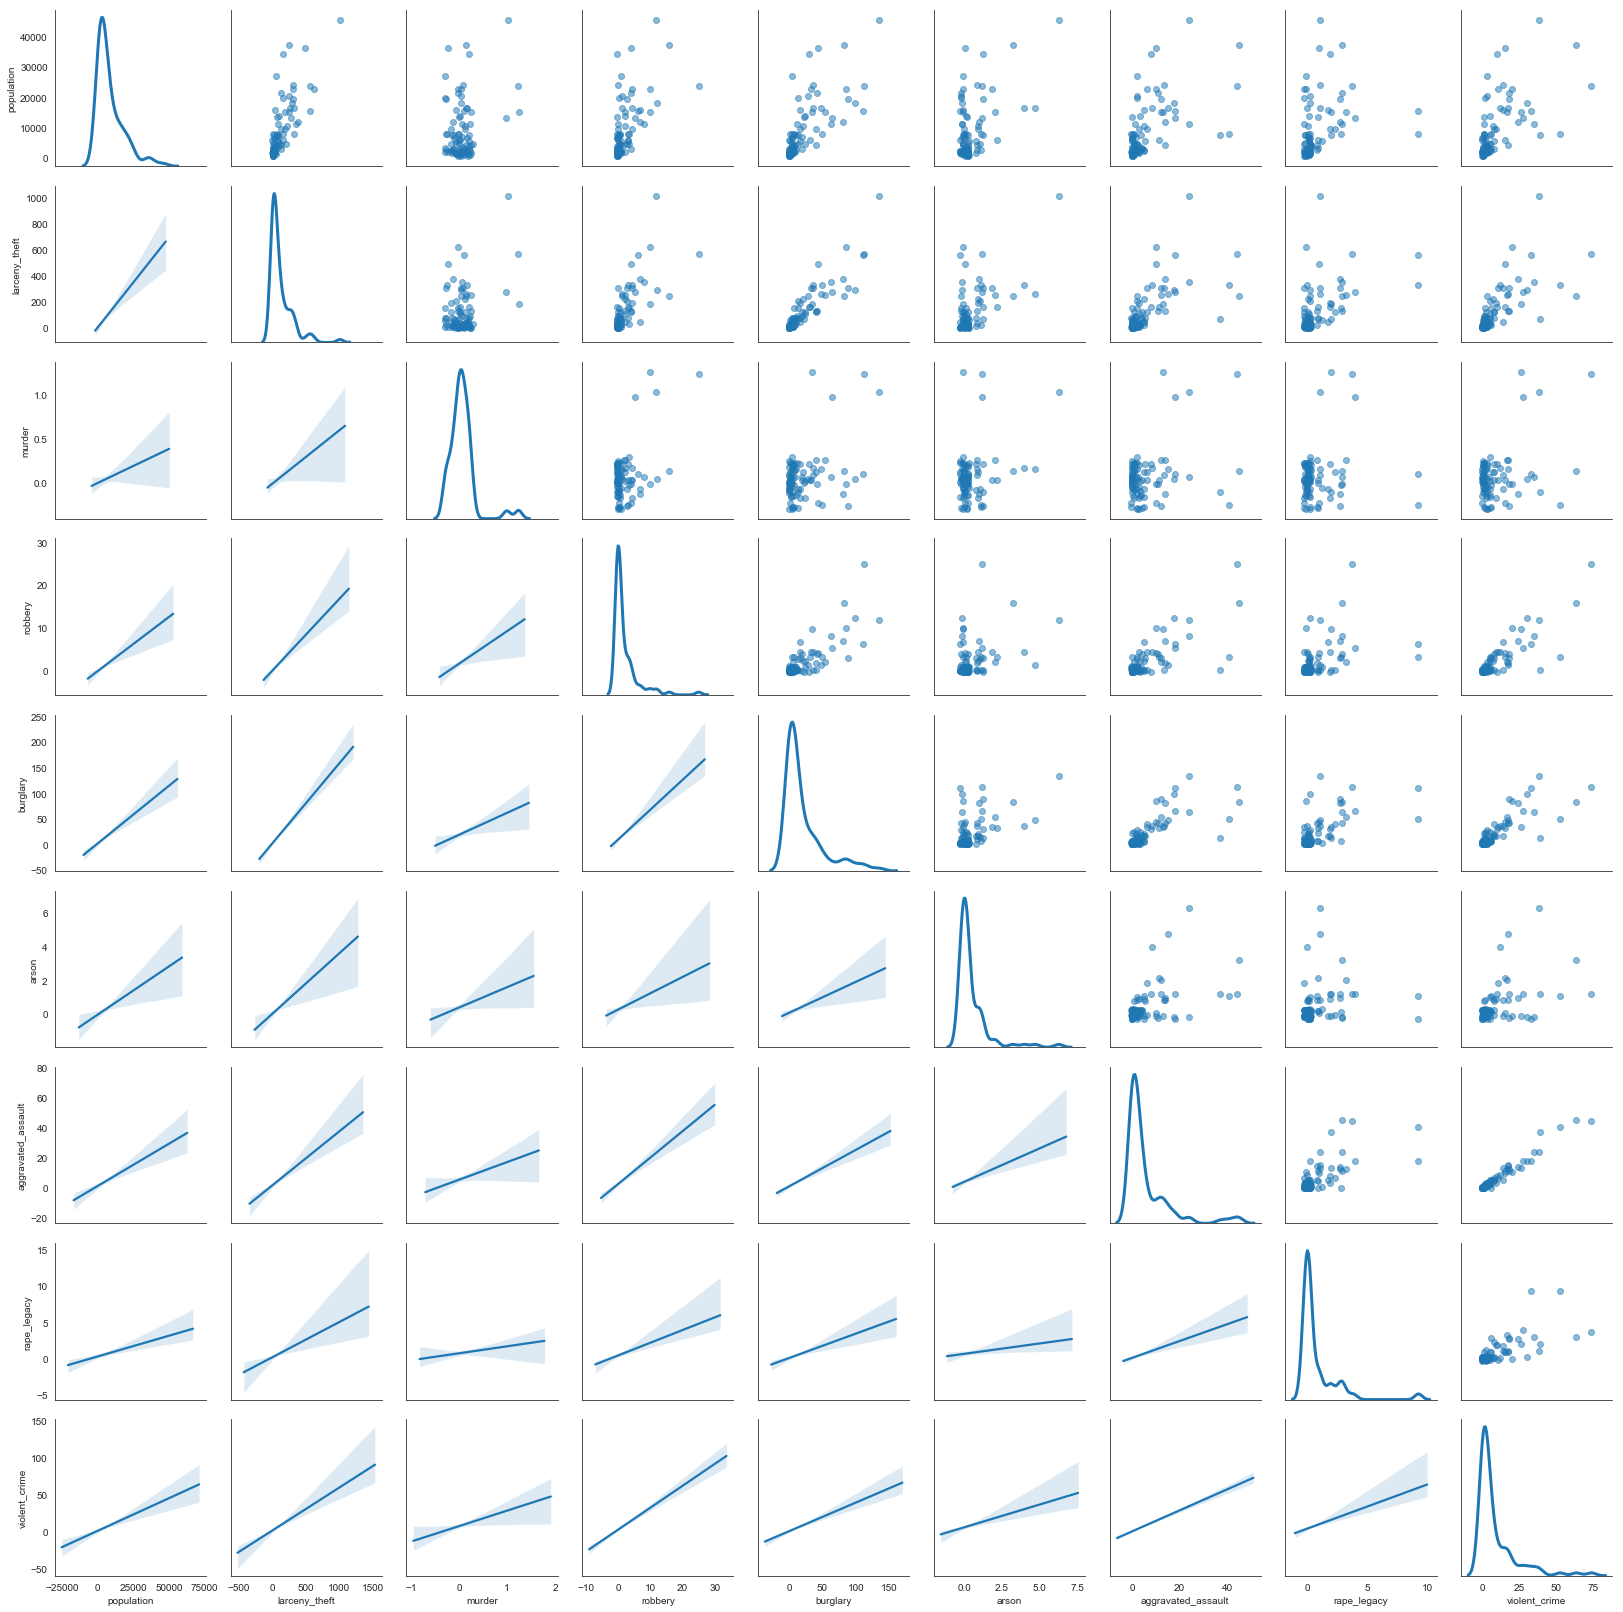

In [42]:
# Make the scatterplot matrix
# Set the default plot aesthetics to be prettier.
sns.set_style("white")

# Take a subset of the data to make plots clearer.
crime_sel = crime[['property_crime', 'population', 'larceny_theft', 'murder', 'robbery','burglary','arson','aggravated_assault','rape_legacy','violent_crime']]

# Because the variables can only take integer values between 0 and 10, points
# on the scatterplot will hide one another. To better see all the points, we
# create a dataframe of random noise (or "jitter") and add it only when plotting.

# Make a copy of the data to add jitter to and plot.
crime_jittered = crime_sel.loc[:, 'population':'violent_crime'].dropna()

# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(crime_jittered.shape)),
    columns=crime_jittered.columns
)

# Combine the data and the noise.
crime_jittered = crime_jittered.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(crime_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

#Some warnings will show up below because the plot does not include a legend.

In [40]:
x = crime[['population','larceny_theft','murder','robbery','burglary','arson','aggravated_assault','rape_legacy','violent_crime']]
y = crime['property_crime']

# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(x, y)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

Coefficients: 
 [ 1.59864747e-04  1.00213939e+00 -1.56947297e+00  7.57895899e-01
  1.09405781e+00 -1.36615477e-01  1.55221480e-01  3.60628986e-01
 -2.95726602e-01]
Intercept: 
 -0.47579640975084203


In [44]:
regr.score(x,y)

0.9998156110633676

In [45]:
# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict() 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.105e+05
Date:                Mon, 25 Mar 2019   Prob (F-statistic):          4.41e-300
Time:                        19:58:32   Log-Likelihood:                -430.28
No. Observations:                 172   AIC:                             878.6
Df Residuals:                     163   BIC:                             906.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.4758      0